In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt

# Data 

In [2]:
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

/home/thor_01/miniconda3/envs/ds2023/lib/python3.9/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

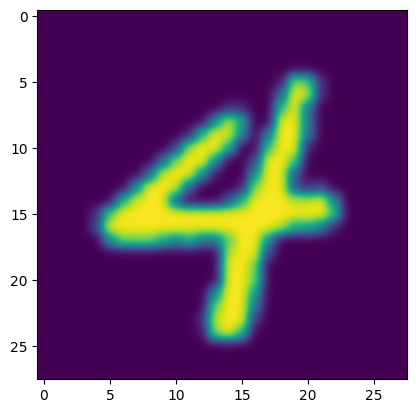

In [4]:

plt.imshow(X_train[0].reshape(28, 28), interpolation="gaussian")

In [25]:
X_train[0].shape

(784,)

Best parameters for RandomForestClassifier: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best score for RandomForestClassifier: 0.9672833333333334
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best parameters for ExtraTreesClassifier: {'max_depth': 50, 'min_samples_split': 2, 'n_estimators': 200}
Best score for ExtraTreesClassifier: 0.97125
Fitting 3 folds for each of 3 candidates, totalling 9 fits

Best parameters for Pipeline: {'svc__C': 10, 'svc__kernel': 'rbf'}
Best score for Pipeline: 0.9682166666666667

Best parameters for KNeighborsClassifier: {'algorithm': 'ball_tree', 'n_neighbors': 3, 'weights': 'distance'}
Best score for KNeighborsClassifier: 0.9702166666666666

In [17]:
# Instantiate RandomForestClassifier with best parameters
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    n_jobs=14
)

# Instantiate ExtraTreesClassifier with best parameters
et_clf = ExtraTreesClassifier(
    n_estimators=200,
    max_depth=50,
    min_samples_split=2,
    n_jobs=14
)

# Instantiate SVC within a Pipeline with best parameters
svm_clf = Pipeline([
    ("standarize", StandardScaler()),
    ("svc", SVC(C=10, kernel='rbf', verbose=2, gamma="scale"))
])

# Instantiate KNeighborsClassifier with best parameters
knn_clf = KNeighborsClassifier(
    n_neighbors=3,
    weights='distance',
    algorithm='ball_tree',
    n_jobs=14
)

hard_voting_ensemble = VotingClassifier(estimators=[
    ("random_forest", rf_clf),
    ("extra_trees", et_clf),
    ("svm", svm_clf),
    ("knn", knn_clf)
], voting="hard")




In [18]:
estimators = [rf_clf, et_clf, svm_clf, hard_voting_ensemble]

for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

[estimator.score(X_val, y_val) for estimator in estimators]

Training the RandomForestClassifier(n_estimators=200, n_jobs=14)
Training the ExtraTreesClassifier(max_depth=50, n_estimators=200, n_jobs=14)
Training the Pipeline(steps=[('standarize', StandardScaler()),
                ('svc', SVC(C=10, verbose=2))])
[LibSVM]*
optimization finished, #iter = 667
obj = -114.279589, rho = -0.188276
nSV = 281, nBSV = 0
.*.*
optimization finished, #iter = 2407
obj = -374.130592, rho = 0.678627
nSV = 948, nBSV = 0
.*.*
optimization finished, #iter = 2051
obj = -273.514078, rho = 0.494663
nSV = 789, nBSV = 0
*.*
optimization finished, #iter = 1399
obj = -186.609627, rho = 0.265258
nSV = 581, nBSV = 0
.*.*
optimization finished, #iter = 2285
obj = -377.029004, rho = 0.412447
nSV = 814, nBSV = 0
.*.*
optimization finished, #iter = 2614
obj = -443.421951, rho = 0.595612
nSV = 890, nBSV = 3
.*
optimization finished, #iter = 1674
obj = -192.622623, rho = 0.667771
nSV = 750, nBSV = 0
.*.*
optimization finished, #iter = 2139
obj = -364.141506, rho = 0.212047
nSV =

[0.9701, 0.9727, 0.9714, 0.9767]

Accuracy: 0.9738
Precision: 0.9738555903143571
Recall: 0.9737132728764033
F1 Score: 0.9737095139053558


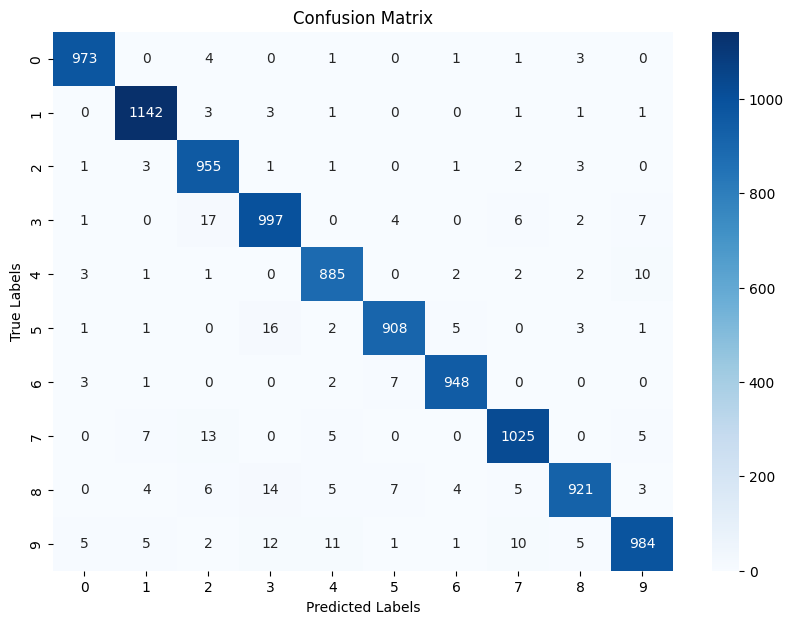

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming hard_voting_ensemble is already trained and X_test, y_test are defined

# Make predictions on the test set
test_predict = hard_voting_ensemble.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, test_predict)
precision = precision_score(y_test, test_predict, average='macro')  # Use 'micro', 'macro', 'weighted' or None based on your problem
recall = recall_score(y_test, test_predict, average='macro')
f1 = f1_score(y_test, test_predict, average='macro')

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Generate and plot the confusion matrix
cm = confusion_matrix(y_test, test_predict)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))  # Adjust labels if necessary
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [20]:
# Using stacking 
from sklearn.ensemble import StackingClassifier

# Define base models
base_models = [
    ("random_forest", rf_clf),
    ("extra_trees", et_clf),
    ("svm", svm_clf),
    ("knn", knn_clf)
]

# Define the final estimator (meta-learner)
final_estimator = LogisticRegression()

stacking_clf = StackingClassifier(estimators=base_models, final_estimator=final_estimator)
# Train the stacking classifier
stacking_clf.fit(X_train, y_train)

[LibSVM]*
optimization finished, #iter = 667
obj = -114.279589, rho = -0.188276
nSV = 281, nBSV = 0
.*.*
optimization finished, #iter = 2407
obj = -374.130592, rho = 0.678627
nSV = 948, nBSV = 0
.*.*
optimization finished, #iter = 2051
obj = -273.514078, rho = 0.494663
nSV = 789, nBSV = 0
*.*
optimization finished, #iter = 1399
obj = -186.609627, rho = 0.265258
nSV = 581, nBSV = 0
.*.*
optimization finished, #iter = 2285
obj = -377.029004, rho = 0.412447
nSV = 814, nBSV = 0
.*.*
optimization finished, #iter = 2614
obj = -443.421951, rho = 0.595612
nSV = 890, nBSV = 3
.*
optimization finished, #iter = 1674
obj = -192.622623, rho = 0.667771
nSV = 750, nBSV = 0
.*.*
optimization finished, #iter = 2139
obj = -364.141506, rho = 0.212047
nSV = 713, nBSV = 1
.*
optimization finished, #iter = 1608
obj = -264.631849, rho = 0.332408
nSV = 597, nBSV = 0
.*.*
optimization finished, #iter = 2182
obj = -387.021081, rho = 0.765725
nSV = 762, nBSV = 2
.*
optimization finished, #iter = 1871
obj = -386.

/home/thor_01/miniconda3/envs/ds2023/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(estimators=[('random_forest',
                                RandomForestClassifier(n_estimators=200,
                                                       n_jobs=14)),
                               ('extra_trees',
                                ExtraTreesClassifier(max_depth=50,
                                                     n_estimators=200,
                                                     n_jobs=14)),
                               ('svm',
                                Pipeline(steps=[('standarize',
                                                 StandardScaler()),
                                                ('svc',
                                                 SVC(C=10, verbose=2))])),
                               ('knn',
                                KNeighborsClassifier(algorithm='ball_tree',
                                                     n_jobs=14, n_neighbors=3,
                                                     weights='distance'))],
                   final_estimator=LogisticRegression())

Accuracy: 0.9794
Precision: 0.9793851299737192
Recall: 0.9793289874294857
F1 Score: 0.9793313545374973


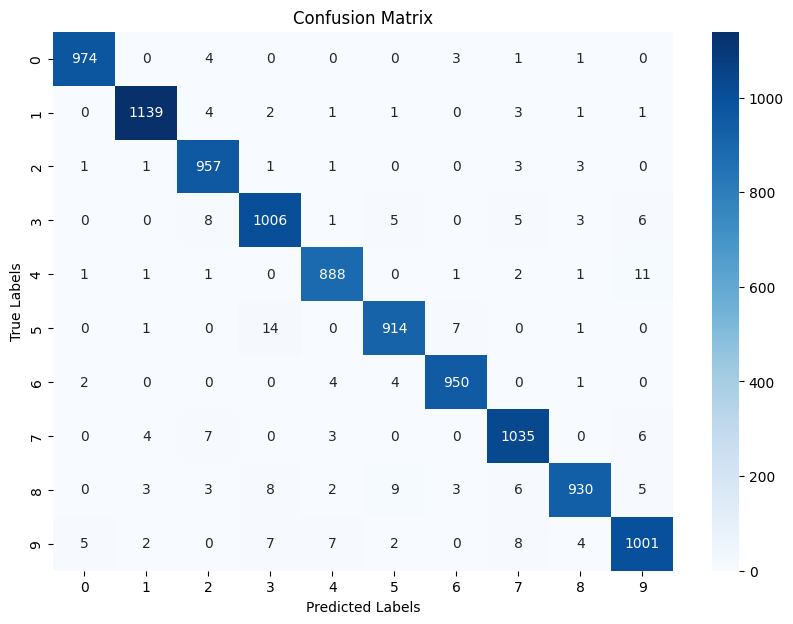

In [21]:
# Make predictions on the test set
test_predict = stacking_clf.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, test_predict)
precision = precision_score(y_test, test_predict, average='macro')  # Use 'micro', 'macro', 'weighted' or None based on your problem
recall = recall_score(y_test, test_predict, average='macro')
f1 = f1_score(y_test, test_predict, average='macro')

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Generate and plot the confusion matrix
cm = confusion_matrix(y_test, test_predict)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))  # Adjust labels if necessary
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Grid Search

In [12]:
# Combine X_train and X_val
X_train_val_combined = np.concatenate((X_train, X_val), axis=0)

# Combine y_train and y_val
y_train_val_combined = np.concatenate((y_train, y_val), axis=0)

# Updating models_params to include k-NN
models_params = [
    (RandomForestClassifier(n_jobs=14), {
        'n_estimators': [100, 200],
        'max_depth': [None, 30, 50],
        'min_samples_split': [2, 5],
    }),
    
    (ExtraTreesClassifier(n_jobs=14), {
        'n_estimators': [100, 200],
        'max_depth': [None, 30, 50],
        'min_samples_split': [2, 5],
    }),

    (Pipeline([
        ("standarize", StandardScaler()),
        ("svc", SVC(verbose=2, gamma="scale"))
    ]), {
        'svc__C': [1, 10, 20],
        'svc__kernel': ['rbf'],
    }),

    (KNeighborsClassifier(n_jobs=14), {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute']
})  
]

# Perform grid search for each model
for model, params in models_params:
    grid_search = GridSearchCV(model, params, cv=3, scoring='accuracy', verbose=2)
    grid_search.fit(X_train_val_combined, y_train_val_combined)
    print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    print(f"Best score for {model.__class__.__name__}: {grid_search.best_score_}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   2.6s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   2.7s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   2.7s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=   2.7s
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=   2.7s
[CV] END max_depth=None, m

Best parameters for RandomForestClassifier: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best score for RandomForestClassifier: 0.9672833333333334
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best parameters for ExtraTreesClassifier: {'max_depth': 50, 'min_samples_split': 2, 'n_estimators': 200}
Best score for ExtraTreesClassifier: 0.97125
Fitting 3 folds for each of 3 candidates, totalling 9 fits

Best parameters for Pipeline: {'svc__C': 10, 'svc__kernel': 'rbf'}
Best score for Pipeline: 0.9682166666666667

Best parameters for KNeighborsClassifier: {'algorithm': 'ball_tree', 'n_neighbors': 3, 'weights': 'distance'}
Best score for KNeighborsClassifier: 0.9702166666666666

# Training final model on all data

In [22]:
# grid search final estimator

# Define base models
base_models = [
    ("random_forest", rf_clf),
    ("extra_trees", et_clf),
    ("svm", svm_clf),
    ("knn", knn_clf)
]

# Define the final estimator (meta-learner)
final_estimator = LogisticRegression(max_iter=1000)

stacking_clf = StackingClassifier(estimators=base_models, final_estimator=final_estimator)
# Train the stacking classifier
stacking_clf.fit(X, y)

[LibSVM]*
optimization finished, #iter = 830
obj = -138.974264, rho = -0.157488
nSV = 328, nBSV = 1
..*
optimization finished, #iter = 2971
obj = -450.250991, rho = 0.674339
nSV = 1139, nBSV = 1
.*.*
optimization finished, #iter = 2524
obj = -330.848976, rho = 0.515880
nSV = 944, nBSV = 0
.*
optimization finished, #iter = 1682
obj = -227.305066, rho = 0.315899
nSV = 702, nBSV = 0
.*.*
optimization finished, #iter = 2926
obj = -467.998095, rho = 0.410332
nSV = 986, nBSV = 0
..*.*
optimization finished, #iter = 3157
obj = -547.984751, rho = 0.603567
nSV = 1087, nBSV = 5
.*.*
optimization finished, #iter = 2101
obj = -243.858670, rho = 0.670605
nSV = 938, nBSV = 0
.*.*
optimization finished, #iter = 2516
obj = -472.765858, rho = 0.235852
nSV = 857, nBSV = 4
.*.*
optimization finished, #iter = 2215
obj = -359.378512, rho = 0.378173
nSV = 770, nBSV = 1
.*.*
optimization finished, #iter = 2737
obj = -548.478855, rho = 0.752714
nSV = 940, nBSV = 8
.*.*
optimization finished, #iter = 2372
obj 

/home/thor_01/miniconda3/envs/ds2023/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(estimators=[('random_forest',
                                RandomForestClassifier(n_estimators=200,
                                                       n_jobs=14)),
                               ('extra_trees',
                                ExtraTreesClassifier(max_depth=50,
                                                     n_estimators=200,
                                                     n_jobs=14)),
                               ('svm',
                                Pipeline(steps=[('standarize',
                                                 StandardScaler()),
                                                ('svc',
                                                 SVC(C=10, verbose=2))])),
                               ('knn',
                                KNeighborsClassifier(algorithm='ball_tree',
                                                     n_jobs=14, n_neighbors=3,
                                                     weights='distance'))],
                   final_estimator=LogisticRegression(max_iter=1000))

In [24]:
from joblib import dump

dump(stacking_clf, '/home/thor_01/Documents/EC/ensemble-learning-sklearn/trained_models/stacking_clf.joblib')

['/home/thor_01/Documents/EC/ensemble-learning-sklearn/trained_models/stacking_clf.joblib']